In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "png"

from data import *
from plotting import *
from regression import *
from utils import *




In [3]:
# Load data
pcd_df = load_pcd_df()


In [4]:
access_df = pcd_df.dropna(subset=['Model accessibility'])
len(access_df)

971

In [5]:
# number of models with marked model accessibility and unmarked code accessibility
len(access_df[access_df['Code accessibility'].isna()])

137

In [6]:
model_open_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
# model_closed_categories = ['API access', 'Hosted access (no API)', 'Unreleased']
code_open_categories = ['Open source', 'Open access (non-commercial)', 'Open access (restricted use)']


# Add open/closed binary columns
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in model_open_categories else 'Closed'
)

access_df['Code open/closed'] = access_df['Code accessibility'].apply(
    # note that this defaults to Closed if NA
    lambda x: 'Open' if x in code_open_categories else 'Closed'
)



/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_71957/2841245226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Model open/closed'] = access_df['Model accessibility'].apply(
/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_71957/2841245226.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Code open/closed'] = access_df['Code accessibility'].apply(


In [7]:
access_df['Composite open'] = 'Model ' + access_df['Model open/closed'].str.lower() + ' Code ' + access_df['Code open/closed'].str.lower()

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_71957/1383663911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Composite open'] = 'Model ' + access_df['Model open/closed'].str.lower() + ' Code ' + access_df['Code open/closed'].str.lower()


In [8]:
access_df.head(8)

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training compute cost (2023 USD),Training dataset size,Sparsity,Model open/closed,Code open/closed,Composite open
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",2023-12-06,NaN,Hosted access (no API),NaN,Unreleased,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,NaN,132000000.0,Industry,NaN,$29827341.92,Gemini 1.0 Ultra,NaN,Closed,Closed,Model closed Code closed
1,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,2023-03-15,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2303.08774,OpenAI,...,NaN,57000000.0,Industry,NaN,$40586592.58,GPT-4,GPT-4,Closed,Closed,Model closed Code closed
2,Mistral Large,Language,Chat,2024-02-26,NaN,API access,NaN,Unreleased,https://mistral.ai/news/mistral-large/,Mistral AI,...,NaN,NaN,Industry,NaN,NaN,Mistral Large,NaN,Closed,Closed,Model closed Code closed
3,Nemotron-4 340B,Language,"Language modelling/generation,Chat",2024-06-14,Permissive commercial license: https://develop...,Open source,NaN,NaN,https://blogs.nvidia.com/blog/nemotron-4-synth...,NVIDIA,...,NaN,NaN,Industry,NaN,NaN,Nemotron-4 340B,NaN,Open,Closed,Model open Code closed
4,MegaScale (Production),Language,Language modelling/generation,2024-02-23,Code for MegaScale (also called veScale) train...,Unreleased,NaN,Unreleased,https://arxiv.org/abs/2402.15627,"ByteDance,Peking University",...,NaN,NaN,"Industry,Academia",NaN,NaN,MegaScale (Production),NaN,Closed,Closed,Model closed Code closed
5,Inflection-2,Language,"Language modelling,Language modelling/generati...",2023-11-22,"via Pi, no API",Hosted access (no API),NaN,Unreleased,https://inflection.ai/inflection-2,Inflection AI,...,NaN,NaN,Industry,NaN,$12961959.00,Inflection-2,NaN,Closed,Closed,Model closed Code closed
6,Inflection-2.5,Language,Chat,2024-03-07,NaN,Hosted access (no API),NaN,Unreleased,https://inflection.ai/inflection-2-5,Inflection AI,...,NaN,NaN,Industry,NaN,NaN,Inflection-2.5,NaN,Closed,Closed,Model closed Code closed
7,PaLM 2,Language,"Language modelling,Language modelling/generation",2023-05-10,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2305.10403,Google,...,NaN,NaN,Industry,NaN,$4865570.06,PaLM 2,NaN,Closed,Closed,Model closed Code closed


In [9]:
model_counts = access_df.groupby('Model accessibility').size().reset_index(name='Counts')
model_counts

,Model accessibility,Counts
0,API access,52
1,Hosted access (no API),23
2,Open access (non-commercial),87
3,Open access (restricted use),63
4,Open source,307
5,Unreleased,439


In [10]:
code_counts = access_df.groupby('Code accessibility').size().reset_index(name='Counts')
code_counts

,Code accessibility,Counts
0,Open access (non-commercial),75
1,Open access (restricted use),7
2,Open source,332
3,Unreleased,420


In [11]:
counts = access_df.groupby(['Model accessibility', 'Code accessibility']).size().reset_index(name='Counts')
pivoted = counts.pivot(index='Model accessibility', columns='Code accessibility', values='Counts').fillna(0).style.format("{:.0f}")

# code access against model access
pivoted

Code accessibility,Open access (non-commercial),Open access (restricted use),Open source,Unreleased
Model accessibility,,,,
API access,0,0,0,31
Hosted access (no API),1,0,1,15
Open access (non-commercial),36,1,16,22
Open access (restricted use),0,4,13,28
Open source,2,1,196,59
Unreleased,36,1,106,265


In [12]:
open_counts = access_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
open_counts = open_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

# code open vs model open
open_counts

Code open/closed,Closed,Open
Model open/closed,,
Closed,369,145
Open,188,269


In [13]:
# check if trends change over time. maybe for the 2x2 
# also could merge cumulative charts here

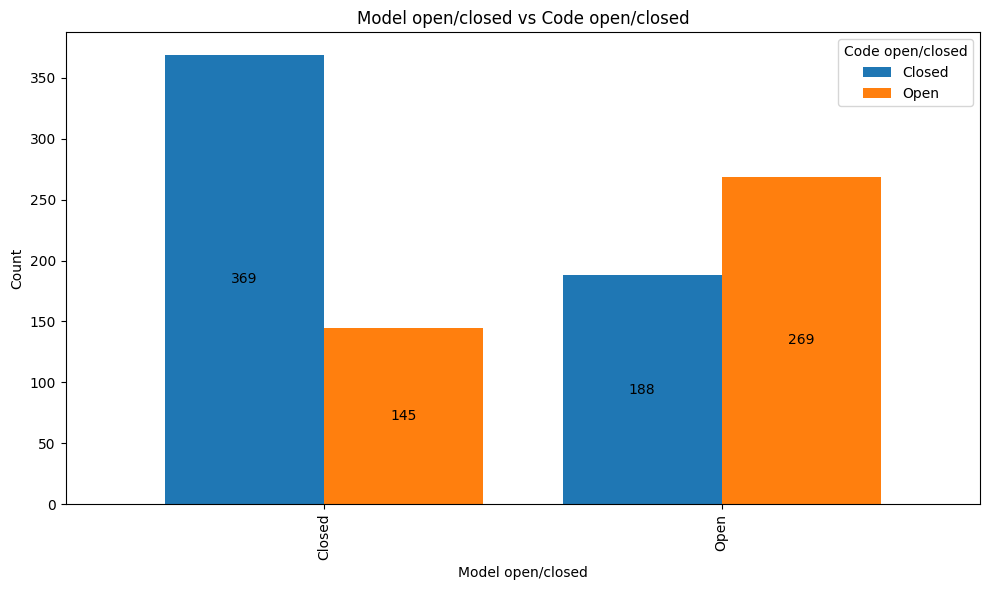

In [14]:
ax = open_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customize the chart
plt.title('Model open/closed vs Code open/closed')
plt.ylabel('Count')


# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

In [15]:
# cumulative chart for the 2x2 status over time?

access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year

access_df

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_71957/1138342693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year


,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training compute cost (2023 USD),Training dataset size,Sparsity,Model open/closed,Code open/closed,Composite open,Year
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",2023-12-06,NaN,Hosted access (no API),NaN,Unreleased,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,132000000.0,Industry,NaN,$29827341.92,Gemini 1.0 Ultra,NaN,Closed,Closed,Model closed Code closed,2023
1,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,2023-03-15,NaN,API access,NaN,Unreleased,https://arxiv.org/abs/2303.08774,OpenAI,...,57000000.0,Industry,NaN,$40586592.58,GPT-4,GPT-4,Closed,Closed,Model closed Code closed,2023
2,Mistral Large,Language,Chat,2024-02-26,NaN,API access,NaN,Unreleased,https://mistral.ai/news/mistral-large/,Mistral AI,...,NaN,Industry,NaN,NaN,Mistral Large,NaN,Closed,Closed,Model closed Code closed,2024
3,Nemotron-4 340B,Language,"Language modelling/generation,Chat",2024-06-14,Permissive commercial license: https://develop...,Open source,NaN,NaN,https://blogs.nvidia.com/blog/nemotron-4-synth...,NVIDIA,...,NaN,Industry,NaN,NaN,Nemotron-4 340B,NaN,Open,Closed,Model open Code closed,2024
4,MegaScale (Production),Language,Language modelling/generation,2024-02-23,Code for MegaScale (also called veScale) train...,Unreleased,NaN,Unreleased,https://arxiv.org/abs/2402.15627,"ByteDance,Peking University",...,NaN,"Industry,Academia",NaN,NaN,MegaScale (Production),NaN,Closed,Closed,Model closed Code closed,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,MuggleMath,"Language,Mathematics","Language modelling/generation,Chat",2023-11-01,https://huggingface.co/OFA-Sys/MuggleMath_7B,Open source,NaN,Open source,https://arxiv.org/abs/2310.05506,"University of Science and Technology of China,...",...,NaN,"Academia,Industry",NaN,NaN,MuggleMath,NaN,Open,Open,Model open Code open,2023
1587,MiniGPT4 + LRV-Instruction,"Language,Vision,Multimodal","Language modelling/generation,Chat,Visual ques...",2024-03-19,https://github.com/FuxiaoLiu/LRV-Instruction\n...,Open source,NaN,Open source,https://arxiv.org/abs/2306.14565,"University of Maryland,Microsoft",...,NaN,"Academia,Industry",NaN,NaN,MiniGPT4 + LRV-Instruction,NaN,Open,Open,Model open Code open,2024
1588,Xiaoice,"Language,Vision,Multimodal","Chat,Image captioning,Visual question answerin...",2019-09-14,NaN,Hosted access (no API),NaN,NaN,https://arxiv.org/abs/1812.08989,Microsoft Research Asia,...,NaN,Industry,NaN,NaN,Xiaoice,NaN,Closed,Closed,Model closed Code closed,2019
1591,GLM-4 (0520),Language,"Language modelling/generation,Question answeri...",2024-06-18,the GLM-4 API at\nhttps://bigmodel.cn,API access,NaN,NaN,https://arxiv.org/abs/2406.12793,Zhipu AI,...,NaN,Industry,checked,NaN,GLM-4,NaN,Closed,Closed,Model closed Code closed,2024


In [16]:
open_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')
open_counts.head(10)


,Year,Model open/closed,Code open/closed,Count
0,2015,Closed,Closed,5
1,2015,Closed,Open,1
2,2015,Open,Open,2
3,2016,Closed,Closed,18
4,2016,Closed,Open,2
5,2016,Open,Closed,1
6,2016,Open,Open,2
7,2017,Closed,Closed,17
8,2017,Closed,Open,13
9,2017,Open,Open,1


In [17]:
open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

open_counts.head(20)

,Year,Model open/closed,Code open/closed,Count,Cumulative
0,2015,Closed,Closed,5,5
1,2015,Closed,Open,1,1
2,2015,Open,Open,2,2
3,2016,Closed,Closed,18,23
4,2016,Closed,Open,2,3
5,2016,Open,Closed,1,1
6,2016,Open,Open,2,4
7,2017,Closed,Closed,17,40
8,2017,Closed,Open,13,16
9,2017,Open,Open,1,5


In [18]:
total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
total_counts


,Year,Yearly Total,Cumulative Total
0,2015,8,8
1,2016,23,31
2,2017,31,62
3,2018,67,129
4,2019,141,270
5,2020,95,365
6,2021,144,509
7,2022,131,640
8,2023,234,874
9,2024,78,952


In [19]:
open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0)
open_counts_wide

Model open/closed Closed        Open       
Code open/closed  Closed  Open  Open Closed
Year                                       
2015                 5.0   1.0   2.0    0.0
2016                18.0   2.0   2.0    1.0
2017                17.0  13.0   1.0    0.0
2018                34.0  11.0  20.0    2.0
2019                59.0  35.0  37.0   10.0
2020                41.0  15.0  30.0    9.0
2021                53.0  30.0  51.0   10.0
2022                33.0  21.0  48.0   29.0
2023                62.0  10.0  67.0   95.0
2024                32.0   3.0  11.0   32.0

In [20]:
open_counts_wide = open_counts_wide.reset_index()
open_counts_wide

Model open/closed  Year Closed        Open       
Code open/closed        Closed  Open  Open Closed
0                  2015    5.0   1.0   2.0    0.0
1                  2016   18.0   2.0   2.0    1.0
2                  2017   17.0  13.0   1.0    0.0
3                  2018   34.0  11.0  20.0    2.0
4                  2019   59.0  35.0  37.0   10.0
5                  2020   41.0  15.0  30.0    9.0
6                  2021   53.0  30.0  51.0   10.0
7                  2022   33.0  21.0  48.0   29.0
8                  2023   62.0  10.0  67.0   95.0
9                  2024   32.0   3.0  11.0   32.0

In [21]:
print(open_counts_wide.columns.to_list())
print(open_counts_wide.index.names)

[('Year', ''), ('Closed', 'Closed'), ('Closed', 'Open'), ('Open', 'Open'), ('Open', 'Closed')]
[None]


In [22]:
# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

open_counts_wide

,Year,Model Closed Code Closed,Model Closed Code Open,Model Open Code Open,Model Open Code Closed
0,2015,5.0,1.0,2.0,0.0
1,2016,18.0,2.0,2.0,1.0
2,2017,17.0,13.0,1.0,0.0
3,2018,34.0,11.0,20.0,2.0
4,2019,59.0,35.0,37.0,10.0
5,2020,41.0,15.0,30.0,9.0
6,2021,53.0,30.0,51.0,10.0
7,2022,33.0,21.0,48.0,29.0
8,2023,62.0,10.0,67.0,95.0
9,2024,32.0,3.0,11.0,32.0


In [23]:
# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled.head(20)

,Year,Category,Count
0,2015,Model Closed Code Closed,5.0
1,2016,Model Closed Code Closed,18.0
2,2017,Model Closed Code Closed,17.0
3,2018,Model Closed Code Closed,34.0
4,2019,Model Closed Code Closed,59.0
5,2020,Model Closed Code Closed,41.0
6,2021,Model Closed Code Closed,53.0
7,2022,Model Closed Code Closed,33.0
8,2023,Model Closed Code Closed,62.0
9,2024,Model Closed Code Closed,32.0


In [24]:
open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()
open_counts_filled.head(20)

,Year,Category,Count,Cumulative for Category
0,2015,Model Closed Code Closed,5.0,5.0
1,2016,Model Closed Code Closed,18.0,23.0
2,2017,Model Closed Code Closed,17.0,40.0
3,2018,Model Closed Code Closed,34.0,74.0
4,2019,Model Closed Code Closed,59.0,133.0
5,2020,Model Closed Code Closed,41.0,174.0
6,2021,Model Closed Code Closed,53.0,227.0
7,2022,Model Closed Code Closed,33.0,260.0
8,2023,Model Closed Code Closed,62.0,322.0
9,2024,Model Closed Code Closed,32.0,354.0


In [25]:
with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']
with_totals.head(20)

,Year,Category,Count,Cumulative for Category,Yearly Total,Cumulative Total,proportion
0,2015,Model Closed Code Closed,5.0,5.0,8,8,0.625000
1,2016,Model Closed Code Closed,18.0,23.0,23,31,0.741935
2,2017,Model Closed Code Closed,17.0,40.0,31,62,0.645161
3,2018,Model Closed Code Closed,34.0,74.0,67,129,0.573643
4,2019,Model Closed Code Closed,59.0,133.0,141,270,0.492593
5,2020,Model Closed Code Closed,41.0,174.0,95,365,0.476712
6,2021,Model Closed Code Closed,53.0,227.0,144,509,0.445972
7,2022,Model Closed Code Closed,33.0,260.0,131,640,0.406250
8,2023,Model Closed Code Closed,62.0,322.0,234,874,0.368421
9,2024,Model Closed Code Closed,32.0,354.0,78,952,0.371849


In [48]:
# sort using custom order
custom_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']
with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=custom_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')

,Year,Category,Count,Cumulative for Category,Yearly Total,Cumulative Total,proportion,Category_sorted
0,2015,Model Closed Code Closed,5.0,5.0,8,8,0.625000,Model Closed Code Closed
1,2016,Model Closed Code Closed,18.0,23.0,23,31,0.741935,Model Closed Code Closed
2,2017,Model Closed Code Closed,17.0,40.0,31,62,0.645161,Model Closed Code Closed
3,2018,Model Closed Code Closed,34.0,74.0,67,129,0.573643,Model Closed Code Closed
4,2019,Model Closed Code Closed,59.0,133.0,141,270,0.492593,Model Closed Code Closed
5,2020,Model Closed Code Closed,41.0,174.0,95,365,0.476712,Model Closed Code Closed
6,2021,Model Closed Code Closed,53.0,227.0,144,509,0.445972,Model Closed Code Closed
7,2022,Model Closed Code Closed,33.0,260.0,131,640,0.406250,Model Closed Code Closed
8,2023,Model Closed Code Closed,62.0,322.0,234,874,0.368421,Model Closed Code Closed
9,2024,Model Closed Code Closed,32.0,354.0,78,952,0.371849,Model Closed Code Closed


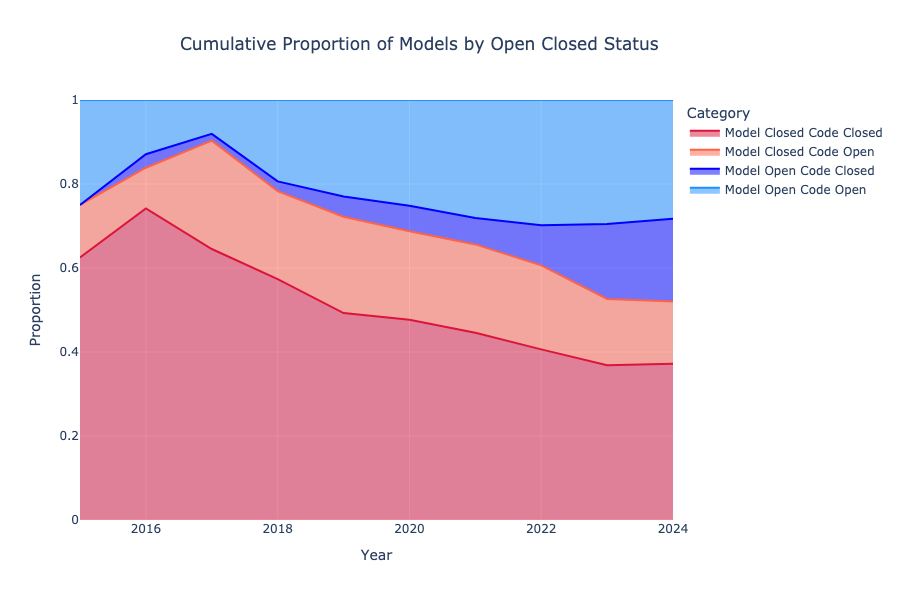

In [54]:
colors = ['crimson', 'tomato', 'blue', 'dodgerblue']


fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative Proportion of Models by Open Closed Status', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)
fig